In [43]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import numpy as np

BASE_DIR = ".."
TEST_DIR = os.path.join(BASE_DIR, "data/test_v2")

In [44]:
@tf.keras.utils.register_keras_serializable()
class Upsample(keras.layers.Layer):
    def __init__(self, filters, size, name, use_dropout=False, **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        self.size = size
        self.use_dropout = use_dropout
        self.conv_transpose = keras.layers.Conv2DTranspose(
            filters=self.filters, kernel_size=self.size, strides=2, 
            padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02),
            use_bias=False)
        self.batch_norm = keras.layers.BatchNormalization()
        if self.use_dropout:
            self.dropout = keras.layers.Dropout(rate=0.5)
        self.relu = keras.layers.ReLU()
   
    def call(self, inputs):
        x = self.conv_transpose(inputs)
        x = self.batch_norm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        return x
        
    def get_config(self):
        return dict(filters=self.filters, size=self.size, 
                    use_dropout=self.use_dropout, 
                    **super().get_config())

@keras.saving.register_keras_serializable()
class UNetMobile(keras.Model):
    def __init__(
        self, input_shape=[224, 224, 3], output_channels=1, 
        name="unet_mobile", **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.output_channels = output_channels
        self._input_shape = input_shape
        self.layer_to_reuse = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        self.base_model = keras.applications.MobileNetV2(
            input_shape=input_shape, weights="imagenet", include_top=False
        )
        self.base_model_outputs = [
            self.base_model.get_layer(name).output for name in self.layer_to_reuse
        ]
        self.down_stack = keras.Model(
            inputs=self.base_model.input, 
            outputs=self.base_model_outputs
        )
        
        # Freeze the weights of the base model
        self.down_stack.trainable = False
        
        # Define upsampling layers
        self.n_filters = [512, 256, 128, 64]
        params = [(f, 3, f"upsample_{f}") for f in self.n_filters]
        self.up_stack = [Upsample(*p_set) for p_set in params]
        
        # Define the last convolutional layer
        self.last_conv = keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3, strides=2,
            padding='same', dtype='float32')
        
    def call(self, inputs):
        x = self.down_stack(inputs)
        skips = reversed(x[:-1])
        x = x[-1]
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            concat = keras.layers.Concatenate()
            x = concat([x, skip])
        x = self.last_conv(x)
        return x
    
    def summary(self):
        x = keras.Input(shape=(224, 224, 3))
        model = keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

def predict_mask(img_path, model, threshold=0.):
    """
    Get single prediction from model given full path to the image
    Returns: (image, predicted mask)
    """
    # load image
    image = tf.keras.utils.load_img(img_path)
    # convert to array
    image_arr = tf.keras.utils.img_to_array(image)
    # get shape
    image_shape = image_arr.shape
    # resize to the shape required by the model
    rescaled = tf.image.resize(image_arr, [224, 224]) / 127.5 - 1
    # predict mask for the image
    pred_mask = model.predict(tf.expand_dims(rescaled, axis=0), verbose=0)
    # apply thresholding
    pred_mask = tf.cast(pred_mask > threshold, tf.int32)
    # resize mask to the image original size
    pred_mask = tf.image.resize(pred_mask, [image_shape[0], image_shape[1]])
    # remove batch dimension
    pred_mask = tf.squeeze(pred_mask)
    return image, pred_mask

def get_batch_preds(paths, model):
    """
    Get predictions for batch of images given list of paths to images and a model
    Returns: list of (image, mask) pairs
    """
    preds = []
    for i, path in enumerate(paths):
        image, mask = predict_mask(path, model)
        preds.append((image, mask))
        with open(f'../results/mask_{i}.npy', 'wb') as f:
            np.save(f, mask.numpy())
    return preds

def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

def show_predictions(model, preds):
    for image, mask in preds:
        display([image, mask])

In [45]:
# load model
model = keras.models.load_model("../models/model.keras", compile=False)

In [46]:
# get image paths from the test directory
paths = [os.path.join(TEST_DIR, path) for path in os.listdir(TEST_DIR)]
# predictions
preds = get_batch_preds(paths, model)

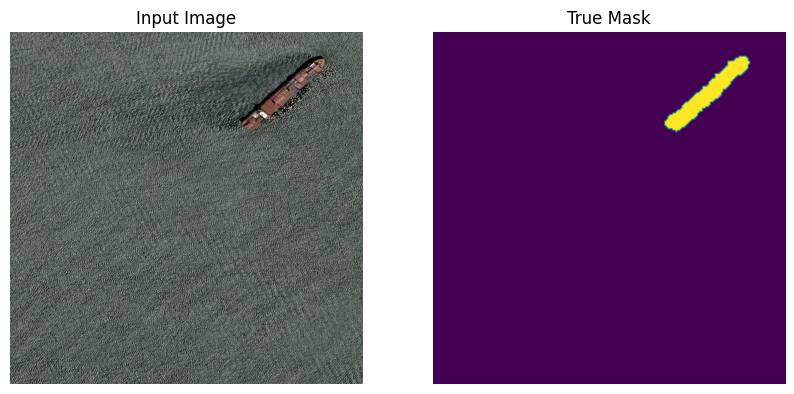

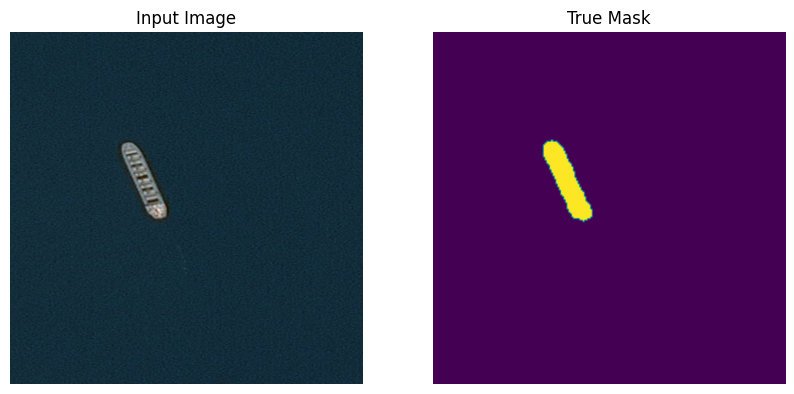

In [47]:
show_predictions(model, preds)

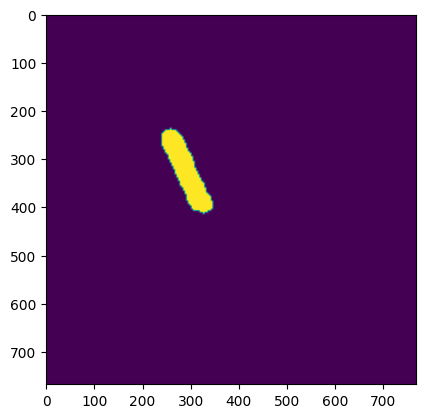

In [48]:
plt.imshow(np.load("../results/mask_1.npy"))